### Dependencies for the process

In [7]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from scipy.fft import fft2, fftshift
from scipy.stats import kurtosis
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import shap



/home/alejandra/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Extraction of the features

In [8]:
def two_simple_features(image_path):
    img = Image.open(image_path).convert("RGB")
    gray = np.array(img.convert("L"))
    mean_intensity = float(gray.mean())
    gray_f = gray.astype(np.float32) / 255.0
    gx = cv2.Sobel(gray_f, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=3)
    gy = cv2.Sobel(gray_f, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=3)
    mag = np.sqrt(gx**2 + gy**2)
    thresh = 0.2
    edges = (mag > thresh).astype(np.uint8)
    edge_density = float(edges.mean())
    return mean_intensity, edge_density

# --- FFT features ---

def extract_fft_features(image_path):
    img = Image.open(image_path).convert("L")
    arr = np.array(img, dtype=np.float32)
    f = np.abs(fftshift(fft2(arr)))
    f = f / np.sum(f)
    h, w = f.shape
    cy, cx = h // 2, w // 2
    y, x = np.indices((h, w))
    r = np.sqrt((x - cx)**2 + (y - cy)**2).astype(int)
    radial_mean = np.bincount(r.ravel(), f.ravel()) / np.bincount(r.ravel())
    freqs = np.arange(len(radial_mean))
    valid = (radial_mean > 0)
    slope = np.polyfit(np.log(freqs[valid] + 1), np.log(radial_mean[valid]), 1)[0]
    spectral_flatness = np.exp(np.mean(np.log(radial_mean[valid]))) / np.mean(radial_mean[valid])
    hf_ratio = np.sum(radial_mean[-len(radial_mean)//3:]) / np.sum(radial_mean)
    return {"spectral_slope": slope, "spectral_flatness": spectral_flatness, "high_freq_ratio": hf_ratio}

# --- Color Features ---

def extract_color_features(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    r, g, b = img[:,:,0].ravel(), img[:,:,1].ravel(), img[:,:,2].ravel()
    corr_rg = np.corrcoef(r,g)[0,1]
    corr_rb = np.corrcoef(r,b)[0,1]
    corr_gb = np.corrcoef(g,b)[0,1]
    ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    cb, cr = ycrcb[:,:,2].ravel(), ycrcb[:,:,1].ravel()
    kurt_cb = kurtosis(cb)
    kurt_cr = kurtosis(cr)
    lap_cb = cv2.Laplacian(ycrcb[:,:,2], cv2.CV_64F).ravel()
    lap_cr = cv2.Laplacian(ycrcb[:,:,1], cv2.CV_64F).ravel()
    kurt_lap_cb = kurtosis(lap_cb)
    kurt_lap_cr = kurtosis(lap_cr)
    return {
        "corr_rg": corr_rg, "corr_rb": corr_rb, "corr_gb": corr_gb,
        "kurt_cb": kurt_cb, "kurt_cr": kurt_cr,
        "kurt_lap_cb": kurt_lap_cb, "kurt_lap_cr": kurt_lap_cr
    }

# --- Texture (GLCM) ---

def extract_glcm_features(image_path):
    img = Image.open(image_path).convert("L")
    gray = np.array(img, dtype=np.uint8)
    gray_q = (gray / 4).astype(np.uint8)
    distances = [1,2,4]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(gray_q, distances=distances, angles=angles, levels=64, symmetric=True, normed=True)
    feats = {}
    for prop in ["contrast","homogeneity","energy","correlation"]:
        feats[prop] = graycoprops(glcm, prop).mean()
    return feats

# --- Combined function ---

def extract_all_features(image_path):
    base_f = {}
    base_f["mean_intensity"], base_f["edge_density"] = two_simple_features(image_path)
    fft_f = extract_fft_features(image_path)
    color_f = extract_color_features(image_path)
    glcm_f = extract_glcm_features(image_path)
    all_f = {**base_f, **fft_f, **color_f, **glcm_f}
    return all_f



### Image loading

In [9]:
rows = []

for folder, label in [("test/ai", 1), ("test/nature", 0)]:
    for fname in os.listdir(folder):
        path = os.path.join(folder, fname)
        if not os.path.isfile(path):
            continue
        feats = extract_all_features(path)
        feats["label"] = label
        feats["file_path"] = path
        rows.append(feats)

df = pd.DataFrame(rows)
df.to_csv("features.csv", index=False)
display(df.head())

/tmp/ipykernel_27142/1015644447.py:44: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_cb = kurtosis(cb)
/tmp/ipykernel_27142/1015644447.py:45: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_cr = kurtosis(cr)


,mean_intensity,edge_density,spectral_slope,spectral_flatness,high_freq_ratio,corr_rg,corr_rb,corr_gb,kurt_cb,kurt_cr,kurt_lap_cb,kurt_lap_cr,contrast,homogeneity,energy,correlation,label,file_path
0,8.100058,0.029755,-0.740470,0.199485,0.061855,0.981788,0.948563,0.977745,8.141683,93.584514,6.404279,9.792148,2.054141,0.891639,0.498741,0.835291,1,test/ai/192_midjourney_198.png
1,137.648685,0.150115,-2.024504,0.010455,0.000675,0.975963,0.887313,0.952008,-1.382304,-0.645302,1.364563,1.649841,8.494331,0.715015,0.106111,0.970973,1,test/ai/668_midjourney_100.png
2,110.396964,0.233206,-1.060121,0.049547,0.008950,0.988707,0.925468,0.968647,-0.085645,0.079679,1.438155,1.153110,11.889496,0.424691,0.066855,0.923103,1,test/ai/481_midjourney_34.png
3,132.233554,0.124306,-1.654471,0.014863,0.001182,0.894392,0.894177,0.986881,1.607135,-1.250403,0.550855,0.579919,4.092669,0.589388,0.074729,0.988499,1,test/ai/539_midjourney_100.png
4,105.781536,0.126808,-1.558593,0.016256,0.002135,0.956807,0.871157,0.972414,-0.218557,-0.393523,1.205813,1.248880,5.240954,0.671615,0.090990,0.991042,1,test/ai/891_midjourney_88.png


### Random Forest model, Performance metrics, Classification Report,Confusion matrix

Matplotlib is building the font cache; this may take a moment.


Precision: 0.891  Recall: 0.886  F1-score: 0.889

 Classification Report
              precision    recall  f1-score   support

           0      0.887     0.892     0.889       500
           1      0.891     0.886     0.889       500

    accuracy                          0.889      1000
   macro avg      0.889     0.889     0.889      1000
weighted avg      0.889     0.889     0.889      1000


 Confusion Matrix
[[446  54]
 [ 57 443]]


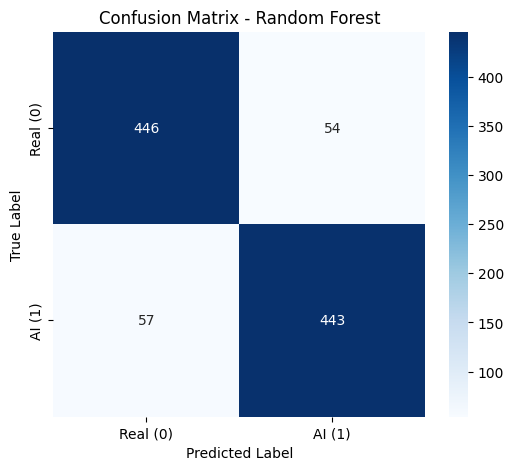

In [12]:
# Random Forest
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X = df.drop(columns=["label","file_path"]).values
y = df["label"].values

# Stratified K-Fold to keep the portion of classes
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Random Forest model
clf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
y_pred = cross_val_predict(clf, X, y, cv=cv)

prec, rec, f1, _ = precision_recall_fscore_support(y, y_pred, average="binary")
print(f"Precision: {prec:.3f}  Recall: {rec:.3f}  F1-score: {f1:.3f}")

print("\n Classification Report")
print(classification_report(y, y_pred, digits=3))

# Confusion Matrix
cm = confusion_matrix(y, y_pred)
print("\n Confusion Matrix")
print(cm)

# Graphic confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Real (0)", "AI (1)"],
            yticklabels=["Real (0)", "AI (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.show()




### Metrics and confusion matrix

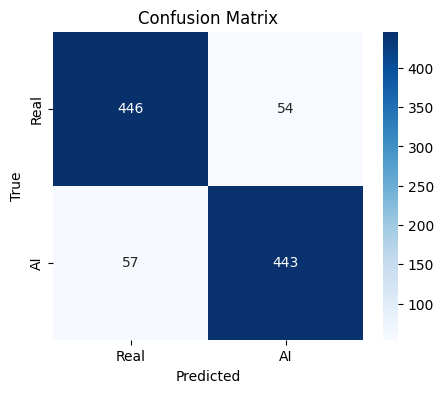

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y, y_pred, labels=[0,1])

# Graphics
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "AI"], yticklabels=["Real", "AI"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



### Importance of features (Gini Importance)

mean_intensity: 0.0275
edge_density: 0.0538
spectral_slope: 0.0582
spectral_flatness: 0.0996
high_freq_ratio: 0.0486
corr_rg: 0.0188
corr_rb: 0.0185
corr_gb: 0.0203
kurt_cb: 0.0197
kurt_cr: 0.0182
kurt_lap_cb: 0.1064
kurt_lap_cr: 0.1659
contrast: 0.1108
homogeneity: 0.0835
energy: 0.0388
correlation: 0.1113


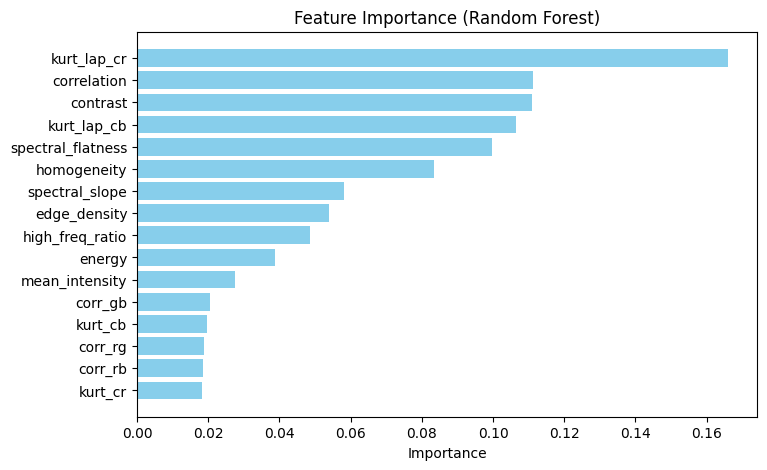

In [14]:
# Train the complete model
clf.fit(X, y)

# importance of the features
importances = clf.feature_importances_
feat_names = df.drop(columns=["label","file_path"]).columns

# Show the results
for name, val in zip(feat_names, importances):
    print(f"{name}: {val:.4f}")

# Graphics
import matplotlib.pyplot as plt
import numpy as np

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8,5))
plt.barh(np.array(feat_names)[indices], importances[indices], color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.gca().invert_yaxis()
plt.show()


### Boxplots of features in the class

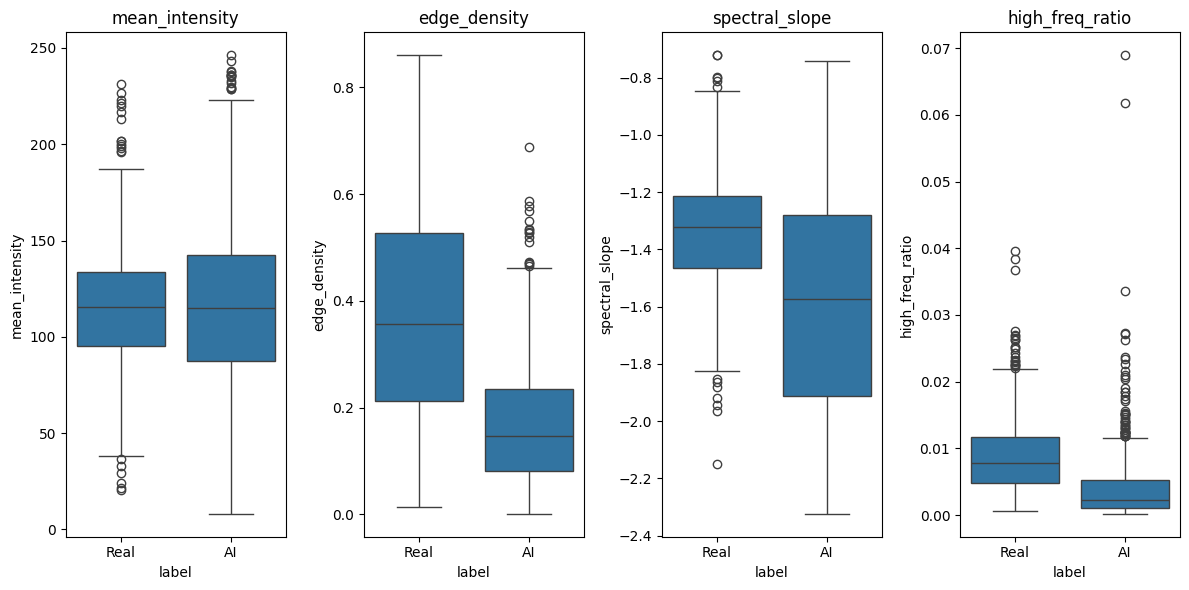

In [15]:
plt.figure(figsize=(12,6))
for i, feat in enumerate(["mean_intensity","edge_density","spectral_slope","high_freq_ratio"]):
    plt.subplot(1,4,i+1)
    sns.boxplot(x="label", y=feat, data=df)
    plt.xticks([0,1], ["Real", "AI"])
    plt.title(feat)
plt.tight_layout()
plt.show()


### Report table summary

In [16]:
from sklearn.metrics import classification_report
report = classification_report(y, y_pred, target_names=["Real", "AI"], output_dict=True)
metrics_df = pd.DataFrame(report).transpose()
display(metrics_df.round(3))


,precision,recall,f1-score,support
Real,0.887,0.892,0.889,500.000
AI,0.891,0.886,0.889,500.000
accuracy,0.889,0.889,0.889,0.889
macro avg,0.889,0.889,0.889,1000.000
weighted avg,0.889,0.889,0.889,1000.000


### Implemented Features

In [17]:
feat_names = df.drop(columns=["label", "file_path"]).columns

for i, name in enumerate(feat_names, 1):
    print(f"{i}. {name}")


1. mean_intensity
2. edge_density
3. spectral_slope
4. spectral_flatness
5. high_freq_ratio
6. corr_rg
7. corr_rb
8. corr_gb
9. kurt_cb
10. kurt_cr
11. kurt_lap_cb
12. kurt_lap_cr
13. contrast
14. homogeneity
15. energy
16. correlation


### Feature Importance Random Forest

,Feature,Importance
0,kurt_lap_cr,0.165879
1,correlation,0.111313
2,contrast,0.110833
3,kurt_lap_cb,0.106360
4,spectral_flatness,0.099611
5,homogeneity,0.083500
6,spectral_slope,0.058157
7,edge_density,0.053829
8,high_freq_ratio,0.048558
9,energy,0.038833


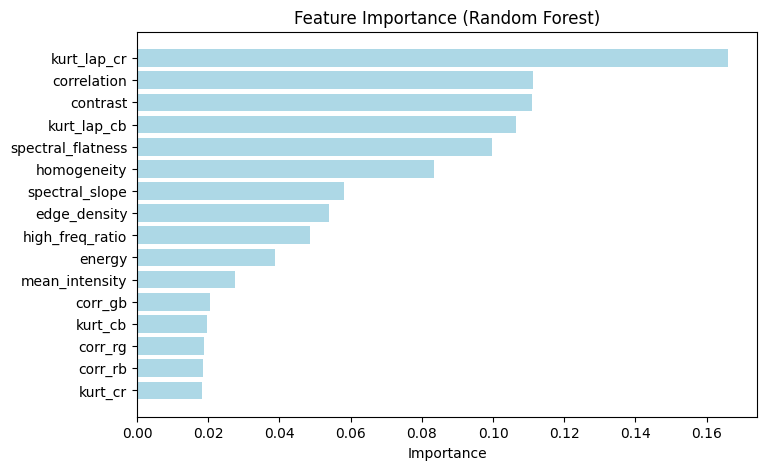

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Train the model
clf.fit(X, y)

# Name and importance features
feat_names = df.drop(columns=["label", "file_path"]).columns
importances = clf.feature_importances_

# Dataframe to show the results
importance_df = pd.DataFrame({
    "Feature": feat_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).reset_index(drop=True)

display(importance_df)

plt.figure(figsize=(8, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='lightblue')
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.show()


### Model configuration

In [19]:
import pandas as pd

config_data = {
    "Parameter": [
        "Model Type", "n_estimators", "max_depth", "criterion",
        "n_splits (K-Fold)", "shuffle", "random_state (CV)",
        "random_state (Model)", "n_jobs"
    ],
    "Value Used": [
        "RandomForestClassifier", 3, None, "gini",
        2, True, 4, 1, "-1 (use all cores)"
    ]
}

config_df = pd.DataFrame(config_data)
display(config_df)


,Parameter,Value Used
0,Model Type,RandomForestClassifier
1,n_estimators,3
2,max_depth,None
3,criterion,gini
4,n_splits (K-Fold),2
5,shuffle,True
6,random_state (CV),4
7,random_state (Model),1
8,n_jobs,-1 (use all cores)
